In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold, GroupKFold, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
import keras.metrics
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/Users/polyanaboss/Desktop/Term paper/Data/processed_data_v.1.0.csv', 
                 index_col = ['day', 'ticker'])

In [6]:
df.dropna(axis = 0, how = 'any', inplace = True)

In [4]:
df.drop([col for col in df.columns if col.startswith('sentiment') or col.startswith('topic')], 
     axis = 1, inplace = True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4476 entries, ('2021-03-04', 'AAPL') to ('2022-03-01', 'PFE')
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   adjclose                4476 non-null   float64
 1   ma_10                   4476 non-null   float64
 2   ma_20                   4476 non-null   float64
 3   ma_30                   4476 non-null   float64
 4   ema_12                  4476 non-null   float64
 5   ema_26                  4476 non-null   float64
 6   rsi_6_sma               4476 non-null   float64
 7   rsi_6_ema               4476 non-null   float64
 8   rsi_12_sma              4476 non-null   float64
 9   rsi_24_sma              4476 non-null   float64
 10  target                  4476 non-null   int64  
 11  trend                   4476 non-null   int64  
 12  target_3_days_previous  4476 non-null   float64
 13  target_5_days_previous  4476 non-null   float64
dtypes:

In [9]:
df.shape

(4476, 14)

In [7]:
df.target.value_counts()

0    2899
1    1577
Name: target, dtype: int64

### Baseline, Binary Target

In [8]:
X = df.drop(['target', 'trend'], axis = 1)
y = df['target'] #target, trend

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)#, stratify = y)
                                                   

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Log reg

In [11]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [15]:
print(metrics.classification_report(lr.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80       785
           1       0.26      0.79      0.39       111

    accuracy                           0.70       896
   macro avg       0.61      0.74      0.60       896
weighted avg       0.87      0.70      0.75       896



In [12]:
import matplotlib.pyplot as plt

In [13]:
# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y_test, lr.predict_proba(X_test)[::, 1]) #model.predict(X_test)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold = {best_thresh}')
print(metrics.classification_report((lr.predict_proba(X_test)[::, 1] > best_thresh), y_test))

Best Threshold = 0.36653518794076856
              precision    recall  f1-score   support

       False       0.78      0.76      0.77       570
        True       0.60      0.62      0.61       326

    accuracy                           0.71       896
   macro avg       0.69      0.69      0.69       896
weighted avg       0.71      0.71      0.71       896



In [15]:
roc_aucs = {}
roc_aucs['Logistic Regression'] = [fpr, tpr]

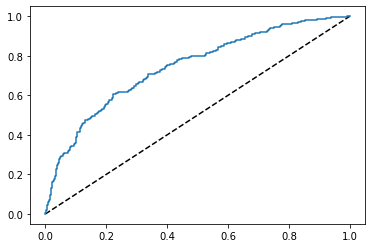

In [14]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label= "Linear")

In [17]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X, y, cv = 10)
scores

array([0.69419643, 0.6875    , 0.71651786, 0.72767857, 0.70758929,
       0.70535714, 0.71588367, 0.68232662, 0.70246085, 0.65324385])

In [14]:
metrics.f1_score((lr.predict_proba(X_test)[::, 1] > best_thresh), y_test)

0.6102719033232628

# Neural Network

In [16]:
model = Sequential()

model.add(Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

model.add(Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

model.add(Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

model.add(Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.2))

#model.add(Dense(256, activation = 'relu'))

#model.add(Dense(256, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid')) 

In [17]:
stopping = keras.callbacks.EarlyStopping(patience = 35, monitor = 'val_loss', restore_best_weights = True, verbose = 1)
reducer = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 10, verbose = 1)
checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/Users/polyanaboss/Desktop/Term paper/separate ML folder',
 monitor = 'val_loss', save_best_only=True, save_freq = 30)

In [18]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'])

In [19]:
history = model.fit(X_train, y_train,
    validation_data = (X_test, y_test), batch_size = 20, epochs = 300, callbacks = [stopping, reducer]) #stopping

Epoch 1/300
179/179 [==============================] - 4s 14ms/step - loss: 0.8156 - accuracy: 0.6004 - val_loss: 0.7207 - val_accuracy: 0.6150
Epoch 2/300
179/179 [==============================] - 1s 6ms/step - loss: 0.6428 - accuracy: 0.6608 - val_loss: 0.7729 - val_accuracy: 0.5971
Epoch 3/300
179/179 [==============================] - 1s 6ms/step - loss: 0.6177 - accuracy: 0.6758 - val_loss: 0.9535 - val_accuracy: 0.6272
Epoch 4/300
179/179 [==============================] - 1s 6ms/step - loss: 0.6375 - accuracy: 0.6535 - val_loss: 0.6473 - val_accuracy: 0.6362
Epoch 5/300
179/179 [==============================] - 1s 6ms/step - loss: 0.6187 - accuracy: 0.6702 - val_loss: 0.6812 - val_accuracy: 0.6306
Epoch 6/300
179/179 [==============================] - 1s 6ms/step - loss: 0.6077 - accuracy: 0.6682 - val_loss: 0.6309 - val_accuracy: 0.6417
Epoch 7/300
179/179 [==============================] - 1s 6ms/step - loss: 0.5911 - accuracy: 0.6901 - val_loss: 0.6447 - val_accuracy: 0.650

In [20]:
print(metrics.classification_report(model.predict_classes(X_test), y_test))

              precision    recall  f1-score   support

           0       0.87      0.75      0.80       648
           1       0.51      0.70      0.59       248

    accuracy                           0.73       896
   macro avg       0.69      0.72      0.70       896
weighted avg       0.77      0.73      0.74       896



In [2]:
ann = keras.models.load_model("ANN_75%.h5")

In [3]:
ann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               14848     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6

In [21]:
# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)) #model.predict(X_test)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh_ann = thresholds[ix]
print(f'Best Threshold = {best_thresh_ann}')
print(metrics.classification_report((model.predict_proba(X_test)> best_thresh_ann), y_test))

Best Threshold = 0.34942111372947693
              precision    recall  f1-score   support

       False       0.71      0.83      0.76       477
        True       0.76      0.61      0.67       419

    accuracy                           0.72       896
   macro avg       0.73      0.72      0.72       896
weighted avg       0.73      0.72      0.72       896



In [22]:
roc_aucs['Neural Network'] = [fpr, tpr]

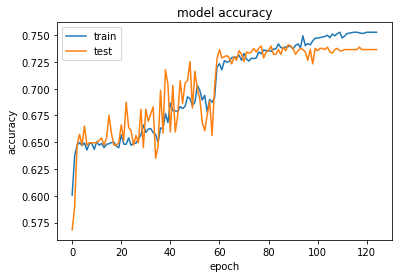

In [99]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# SVM

In [23]:
from sklearn.svm import SVC

In [24]:
svc = SVC(probability = True)
svc.fit(X_train, y_train)

SVC(probability=True)

In [25]:
# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y_test, svc.predict_proba(X_test)[::, 1]) #model.predict(X_test)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh_svc = thresholds[ix]
print(f'Best Threshold = {best_thresh_svc}')
print(metrics.classification_report((svc.predict_proba(X_test)[::, 1] > best_thresh_svc), y_test))

Best Threshold = 0.33510736050175366
              precision    recall  f1-score   support

       False       0.65      0.81      0.72       452
        True       0.74      0.56      0.64       444

    accuracy                           0.68       896
   macro avg       0.69      0.68      0.68       896
weighted avg       0.69      0.68      0.68       896



In [26]:
roc_aucs['SVM'] = [fpr, tpr]

# LightGBM

In [27]:
import lightgbm as lgm

In [28]:
lgm_train = lgm.Dataset(X_train, label = y_train)
lgm_test = lgm.Dataset(X_test, label = y_test)

param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

lgb_model = lgm.train(param, lgm_train, 100, valid_sets=[lgm_test])

[LightGBM] [Info] Number of positive: 1241, number of negative: 2339
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12810
[LightGBM] [Info] Number of data points in the train set: 3580, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346648 -> initscore=-0.633806
[LightGBM] [Info] Start training from score -0.633806
[1]	valid_0's auc: 0.623693
[2]	valid_0's auc: 0.623639
[3]	valid_0's auc: 0.635637
[4]	valid_0's auc: 0.631922
[5]	valid_0's auc: 0.63205
[6]	valid_0's auc: 0.628189
[7]	valid_0's auc: 0.634784
[8]	valid_0's auc: 0.638069
[9]	valid_0's auc: 0.638127
[10]	valid_0's auc: 0.636017
[11]	valid_0's auc: 0.638093
[12]	valid_0's auc: 0.640883
[13]	valid_0's auc: 0.636142
[14]	valid_0's auc: 0.634415
[15]	valid_0's auc: 0.633464
[16]	valid_0's auc: 0.630176
[17]	valid_0's auc: 0.631069
[18]	valid_0's auc: 0.

In [29]:
# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y_test, lgb_model.predict(X_test)) #model.predict(X_test)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh_lgb = thresholds[ix]
print(f'Best Threshold = {best_thresh_lgb}')
print(metrics.classification_report(( lgb_model.predict(X_test) > best_thresh_lgb), y_test))

Best Threshold = 0.25050189976549464
              precision    recall  f1-score   support

       False       0.46      0.78      0.58       334
        True       0.78      0.46      0.58       562

    accuracy                           0.58       896
   macro avg       0.62      0.62      0.58       896
weighted avg       0.66      0.58      0.58       896



In [30]:
roc_aucs['LightGBM'] = [fpr, tpr]

In [31]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [32]:
rf = RandomForestClassifier(n_estimators = 2000, n_jobs = -1)
rf.fit(X_train, y_train)
print(metrics.classification_report( rf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.91      0.63      0.74       805
           1       0.12      0.43      0.18        91

    accuracy                           0.61       896
   macro avg       0.51      0.53      0.46       896
weighted avg       0.83      0.61      0.69       896



In [33]:
# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf.predict_proba(X_test)[::, 1]) #model.predict(X_test)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh_lgb = thresholds[ix]
print(f'Best Threshold = {best_thresh_lgb}')
print(metrics.classification_report(( rf.predict_proba(X_test)[::,1] > best_thresh_lgb), y_test))

Best Threshold = 0.371
              precision    recall  f1-score   support

       False       0.56      0.74      0.64       426
        True       0.67      0.48      0.56       470

    accuracy                           0.60       896
   macro avg       0.61      0.61      0.60       896
weighted avg       0.62      0.60      0.59       896



In [34]:
roc_aucs['Random Forest'] = [fpr, tpr]

In [28]:
print(metrics.f1_score(( rf.predict_proba(X_test)[::,1] > best_thresh_lgb), y_test))

0.5872340425531914


In [37]:
roc_aucs['Random Forest']

2

In [67]:
import matplotlib
matplotlib.rcParams['font.family'] = ['Times']

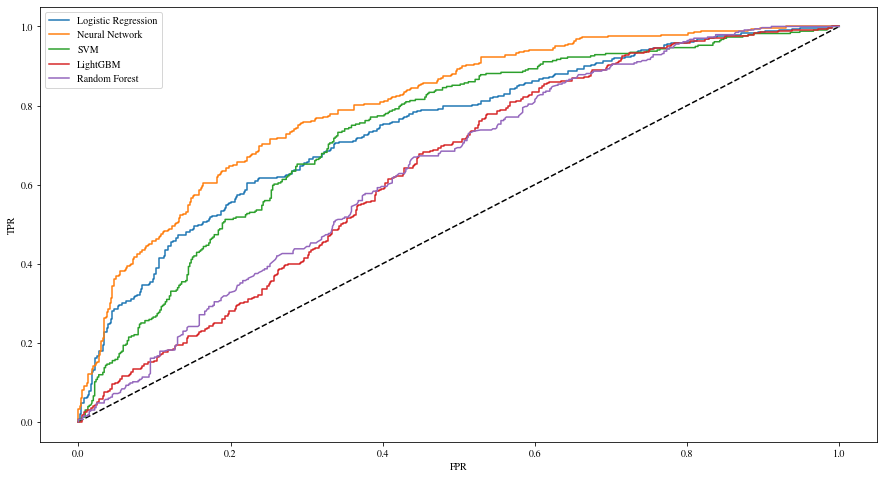

In [69]:
plt.figure(figsize = (15, 8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(roc_aucs['Logistic Regression'][0], roc_aucs['Logistic Regression'][1], label= "Logistic Regression")
plt.plot(roc_aucs['Neural Network'][0], roc_aucs['Neural Network'][1], label= "Neural Network")
plt.plot(roc_aucs['SVM'][0], roc_aucs['SVM'][1], label= "SVM")
plt.plot(roc_aucs['LightGBM'][0], roc_aucs['LightGBM'][1], label= "LightGBM")
plt.plot(roc_aucs['Random Forest'][0], roc_aucs['Random Forest'][1], label= "Random Forest")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
#plt.title('Receiver Operating Characteristic')
plt.show()

In [39]:
import plotly.express as px

In [52]:
len(roc_aucs['Random Forest'][0])
len(roc_aucs['SVM'][0])

381

In [54]:
data = {}
for key in roc_aucs.keys():
    df = pd.DataFrame(roc_aucs[key], index = [f'{key}_fpr', f'{key}_tpr']).transpose()
    data[key] = df

roc_df = pd.concat([data[key] for key in data], axis = 1)
roc_df.head()

,Logistic Regression_fpr,Logistic Regression_tpr,Neural Network_fpr,Neural Network_tpr,SVM_fpr,SVM_tpr,LightGBM_fpr,LightGBM_tpr,Random Forest_fpr,Random Forest_tpr
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.002976,0.000000,0.002976,0.001786,0.000000,0.001786,0.000000,0.000000,0.002976
2,0.000000,0.005952,0.000000,0.032738,0.001786,0.005952,0.005357,0.000000,0.000000,0.005952
3,0.001786,0.005952,0.001786,0.032738,0.003571,0.005952,0.005357,0.017857,0.005357,0.005952
4,0.001786,0.020833,0.001786,0.038690,0.003571,0.008929,0.007143,0.017857,0.005357,0.011905


In [60]:
# Plot 
fig = px.line(roc_df, x = 'Logistic Regression_fpr', y = 'Logistic Regression_tpr')
fig.add_scatter(x = roc_df['SVM_fpr'], y = roc_df['SVM_tpr'])
fig.add_scatter(x = roc_df['Neural Network_fpr'], y = roc_df['Neural Network_tpr'])
fig.add_scatter(x = roc_df['LightGBM_fpr'], y = roc_df['LightGBM_tpr'])
fig.add_scatter(x = roc_df['Random Forest_fpr'], y = roc_df['Random Forest_tpr'])

fig.add_scatter()
fig.show()